In [2]:
pip install transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 6.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.

In [3]:
import json
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import torch
from sklearn.model_selection import train_test_split
import random
import gc
import transformers
from tqdm import tqdm, trange
from typing import Callable, Dict, List, Tuple
from timeit import default_timer as timer
from transformers import EncoderDecoderModel, AutoTokenizer, PreTrainedTokenizer, BatchEncoding, AutoModel
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, WeightedRandomSampler
import os
import json


2025-09-02 20:33:55.025709: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756845235.194644      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756845235.252602      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

MODEL_PATH = "/kaggle/input/llama-3.2/transformers/3b-instruct/1"
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, trust_remote_code=True)
# tokenizer.padding_side = "right"
# tokenizer.pad_token = tokenizer.eos_token
# tokenizer.add_eos_token = True

print(tokenizer.bos_token, tokenizer.eos_token)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH,
    torch_dtype=torch.float16, # Use float16 for memory efficiency on GPUs
    device_map="auto" # Automatically maps model to available devices (like GPU)
)

# Set pad_token_id to eos_token_id for open-end generation
tokenizer.pad_token_id = tokenizer.eos_token_id

# Create a text-generation pipeline
generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.float16,
    device_map="auto"
)

<|begin_of_text|> <|eot_id|>


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


In [5]:
# Fix the random state for reproducibility
def fix_seed(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.

    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

[ ]

SEED = 27
fix_seed(SEED)


In [6]:
import pandas as pd 

def uniform(el):

    """
    Handles the values for multi-value attributes, splitting to list if necessary
    If the input is a list or transformed to a list, values are sorted
    Args:
        el (str or list): The attribute value
    Returns:
        str or list: The attribute value sorted if it is a list, the attribute value otherwise
    """
    if el == el:  # NaN is different from NaN, np.isnan and pd.isna don't work
        if '|' in el:
            el = sorted(el.split('|'))
        elif isinstance(el, list):
            el = sorted(el)
    return el

DATAFRAMES_PATH = '/kaggle/input/nlp-pw' if os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') else './Dataframes'

def create_df_annotations(path: str, language: str, dataset: str):

    """
    Load the dataset + create and save to file a dataframe with the annotations of the arguments.

    Args:
        path (str): path of the folder containing the JSON files
        dataset (str): One of [vat, tp, ecj]
    """
    
    pkl_file_path = f"{DATAFRAMES_PATH}/arg_annotations_{language}_{dataset}.pkl.xz"
    if os.path.isfile(pkl_file_path):
        print(f"Found pkl, loading it - {pkl_file_path}")
        return pd.read_pickle(pkl_file_path)
    print(f"Could not find pkl, reading dataset - {pkl_file_path}")
    temp = []
    files = os.listdir(path)
    files.sort()

    for filename in files:
        if not filename.endswith('.json'):
            print(f"Skipping '{filename}'")
        else:
            print(f"Loading '{filename}'")
            with open(os.path.join(path, filename), 'r', encoding='utf8') as f:
                data = json.load(f)
                annotations = data["annotations"]
                last_full_chain_id = None
                last_text = None
                
                for annotation in annotations:
                    if annotation["name"] != 'conc' and annotation["name"] != 'prem':
                        continue # Ignore intro, nreg, judoff, ...

                    #document = annotation["document"]
                    document = data["document"]["name"]
                    name = annotation["name"]
                    _id = annotation["_id"]
                    argument_chain_id = _id[0]
                    full_chain_id = f'{document}_{argument_chain_id}'
                    last_full_chain_id = full_chain_id
                    incremental_num = _id[1:]
                    text = data["document"]["plainText"][int(annotation["start"]):int(annotation["end"])]
                    last_text = text

                    # attribute extraction, NaN if that attribute is not present
                    T = uniform(annotation["attributes"].get("T", np.nan))
                    SUP = uniform(annotation["attributes"].get("SUP", np.nan))
                    SFF = uniform(annotation["attributes"].get("SFF", np.nan))
                    ATT = uniform(annotation["attributes"].get("ATT", np.nan))
                    INH = uniform(annotation["attributes"].get("INH", np.nan))
                    REPH = uniform(annotation["attributes"].get("REPH", np.nan))
                    S = uniform(annotation["attributes"].get("S", np.nan))
                    text = text.replace('\n','').lstrip('‘’\'\n0123456789.-–…;;) ').rstrip('‘’\'\n.;; ')
                    previous = last_text if last_full_chain_id == full_chain_id else None
                    temp.append([
                        document, name, _id, argument_chain_id, incremental_num, text, T, SUP, SFF, ATT, INH, REPH, S, full_chain_id, previous,
                    ])

    # df creation
    df = pd.DataFrame(temp, columns=[
            'Document', 'Name', 'Id', 'Chain', 'Num', 'Text', 'Type', 'SUP', 'SFF', 'ATT', 'INH', 'REPH', 'Scheme', 'FullChainID', 'Previous'
        ])
    print(f"Saving {len(df)} annotations to {pkl_file_path}")
    df.to_pickle(pkl_file_path)
    df.to_csv(pkl_file_path.replace('.pkl.xz', '.csv'))
    return df

df = create_df_annotations('Data/Dataset/VAT_ITA', 'italian', 'vat')


Found pkl, loading it - /kaggle/input/nlp-pw/arg_annotations_italian_vat.pkl.xz


In [7]:
drop_ind=df[df['Text']==''].index
len(drop_ind)
#remove from dataset rows with no text feature
df.drop(drop_ind,inplace=True)
drop_ind

Index([227, 480, 484, 493, 544, 624, 649, 1653, 1700, 1747, 1749, 1786], dtype='int64')

In [8]:
df_ac = df[~(df['Name'].isnull())].reset_index(drop=True)
df_ac['Name'].unique()
df_tc = df_ac[~(df_ac['Type'].isnull())].reset_index(drop=True)
df_tc.describe()
df_tc['Type'].drop_duplicates()
df_sc = df_tc[~(df_tc['Scheme'].isnull())].reset_index(drop=True)
#print(df_sc.describe())
df_sc['Scheme'].drop_duplicates()

0                      Rule
1                      Itpr
4                      Prec
15             [Itpr, Prec]
21                      Aut
               ...         
1220    [Class, Itpr, Rule]
1237           [Acon, Itpr]
1238          [Class, Tele]
1273     [Prec, Rule, Syst]
1279     [Aut, Itpr, Princ]
Name: Scheme, Length: 63, dtype: object

In [9]:
#need to extract the values from the list, so convert to string, in order to pass them to the multilabelbinarizer

def clean_list(df_sc, column_name):
    for i in range(len(df_sc)):
        x = df_sc.loc[i,column_name]
        if type(x) == list:
            df_sc.loc[i,str(column_name) + "2"] = ",".join(x)
        else:
            try:
                df_sc.loc[i,str(column_name) + "2"] = x
            except:
                print(i,x)
    return df_sc
df_sc = clean_list(df_sc,'Scheme')
df_sc

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous,Scheme2
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,NaN,NaN,Rule,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'...",Rule
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei...,L,NaN,NaN,NaN,NaN,NaN,Itpr,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,Se il ricorso non è stato\n proposto da o ...,Itpr
2,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A1,A,1,Secondo condivisa e costante giurisprudenza (C...,L,NaN,NaN,NaN,NaN,NaN,Rule,2018_847_VAT_OP_2_-1_MB_AF_AN_A,Secondo condivisa e costante giurisprudenza (C...,Rule
3,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A2,A,2,"Tuttavia, nel caso qui in esame, la Comm/ne no...",L,"[A3, A4]",NaN,NaN,NaN,NaN,Itpr,2018_847_VAT_OP_2_-1_MB_AF_AN_A,"Tuttavia, nel caso qui in esame, la Comm/ne no...",Itpr
4,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A3,A,3,A tal proposito si ricorda che la Corte cost. ...,L,NaN,NaN,NaN,NaN,NaN,Prec,2018_847_VAT_OP_2_-1_MB_AF_AN_A,A tal proposito si ricorda che la Corte cost. ...,Prec
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C15,C,15,Sotto questo profilo i Compro Oro sono sottopo...,L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,Sotto questo profilo i Compro Oro sono sottopo...,Rule
1307,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C16,C,16,Tale comunicazione ha luogo quando i destinata...,L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,Tale comunicazione ha luogo quando i destinata...,Rule
1308,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C17,C,17,"Il Ministro dell'interno, con decreto del 17 f...",L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,"Il Ministro dell'interno, con decreto del 17 f...",Rule
1309,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,NaN,NaN,"[Class, Rule]",2021_6075_VAT_OPAM_2_1_PS_AN_C,Tra i soggetti destinatari del decreto sono ri...,"Class,Rule"


In [10]:
a = df_sc.explode(['Scheme'])
sc_label_count = a['Scheme'].value_counts()
remove_c = sc_label_count[sc_label_count < 15]
list(remove_c.index)


['Lit', 'Abs', 'Psy', 'Acon']

In [11]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb_result = mlb.fit_transform([str(df_sc.loc[i,'Scheme2']).split(',') for i in range(len(df_sc))])
df_sc_final1 = pd.concat([df_sc,pd.DataFrame(mlb_result,columns=list(mlb.classes_))],axis=1)
df_sc_final1

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,...,Aut,Class,Itpr,Lit,Prec,Princ,Psy,Rule,Syst,Tele
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei...,L,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
2,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A1,A,1,Secondo condivisa e costante giurisprudenza (C...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
3,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A2,A,2,"Tuttavia, nel caso qui in esame, la Comm/ne no...",L,"[A3, A4]",NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
4,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A3,A,3,A tal proposito si ricorda che la Corte cost. ...,L,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C15,C,15,Sotto questo profilo i Compro Oro sono sottopo...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1307,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C16,C,16,Tale comunicazione ha luogo quando i destinata...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1308,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C17,C,17,"Il Ministro dell'interno, con decreto del 17 f...",L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1309,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,...,0,1,0,0,0,0,0,1,0,0


In [12]:
sc_classes = mlb.classes_
df_sc_labels = df_sc_final1[mlb.classes_]
sc_label_count = df_sc_labels.sum().sort_values(ascending=False)
df_sc_labels
sc_classes

array(['Abs', 'Acon', 'Aut', 'Class', 'Itpr', 'Lit', 'Prec', 'Princ',
       'Psy', 'Rule', 'Syst', 'Tele'], dtype=object)

<BarContainer object of 12 artists>

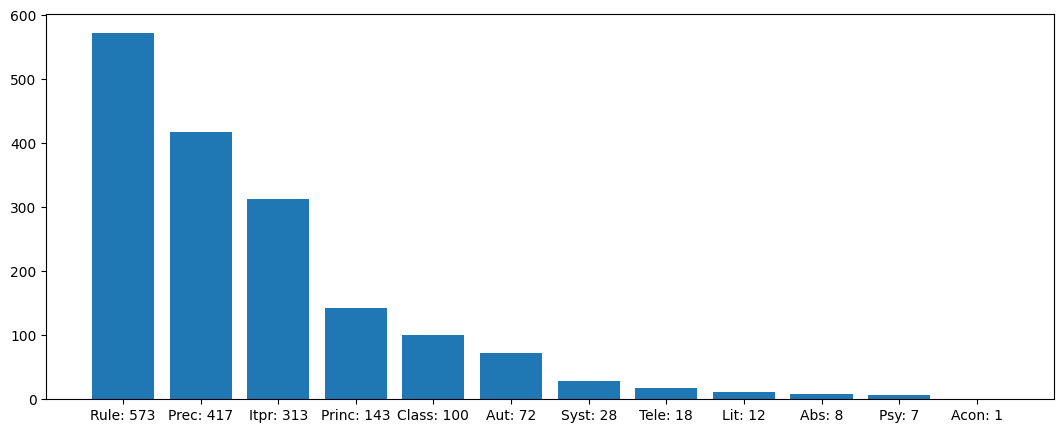

In [13]:
y = np.array(sc_label_count)
#x = np.array(sc_label_count.index)
#added values on x only for convenience
x = [sc_label_count.index[i] + ': ' + str(sc_label_count.iloc[i]) for i in range(len(sc_label_count))]
plt.figure(figsize=(13,5))
plt.bar(x, height=y)

In [14]:
bad_sc_classes = sc_label_count.index[sc_label_count < 15]
sc_classes = sc_label_count.index[sc_label_count >= 15]
print("Removing classes with low number of instances: "+', '.join(bad_sc_classes))
print("Keeping classes with good number of instances: "+', '.join(sc_classes))
good_sc_columns = np.setdiff1d(sc_classes, bad_sc_classes)
print("Remaining columns: "+', '.join(good_sc_columns))
#df_sc_final = df_sc_final1[~df_sc_final1["Scheme2"].isin(bad_sc_classes)].drop(bad_sc_classes,axis=1).reset_index(drop=True)
df_sc_final1

Removing classes with low number of instances: Lit, Abs, Psy, Acon
Keeping classes with good number of instances: Rule, Prec, Itpr, Princ, Class, Aut, Syst, Tele
Remaining columns: Aut, Class, Itpr, Prec, Princ, Rule, Syst, Tele


,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,...,Aut,Class,Itpr,Lit,Prec,Princ,Psy,Rule,Syst,Tele
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei...,L,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
2,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A1,A,1,Secondo condivisa e costante giurisprudenza (C...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
3,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A2,A,2,"Tuttavia, nel caso qui in esame, la Comm/ne no...",L,"[A3, A4]",NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
4,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A3,A,3,A tal proposito si ricorda che la Corte cost. ...,L,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C15,C,15,Sotto questo profilo i Compro Oro sono sottopo...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1307,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C16,C,16,Tale comunicazione ha luogo quando i destinata...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1308,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C17,C,17,"Il Ministro dell'interno, con decreto del 17 f...",L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1309,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,...,0,1,0,0,0,0,0,1,0,0


In [15]:
#df_sc_final['Scheme'].isin(['Acon'])
#updated version, now we are also considering the list type elements
def remove_bad_classes(df_sc,bad_sc_classes):
    df = df_sc
    for i in range(len(df_sc)):
        x = df.loc[i,'Scheme']
        if type(x) == list:
            for q in x:
                if q in bad_sc_classes:
                    #print(x, q)
                    df = df.drop([i])
                    break
        elif x in bad_sc_classes:
            df = df.drop([i])
    df = df.drop(bad_sc_classes,axis=1).reset_index(drop=True)
    return df
df_r = remove_bad_classes(df_sc_final1,bad_sc_classes)
df_sc_final = df_r
df_sc_final.columns

Index(['Document', 'Name', 'Id', 'Chain', 'Num', 'Text', 'Type', 'SUP', 'SFF',
       'ATT', 'INH', 'REPH', 'Scheme', 'FullChainID', 'Previous', 'Scheme2',
       'Aut', 'Class', 'Itpr', 'Prec', 'Princ', 'Rule', 'Syst', 'Tele'],
      dtype='object')

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb_result = mlb.fit_transform([str(df_sc.loc[i,'Scheme2']).split(',') for i in range(len(df_sc))])
df_sc_final1 = pd.concat([df_sc,pd.DataFrame(mlb_result,columns=list(mlb.classes_))],axis=1)
df_sc_final1

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,...,Aut,Class,Itpr,Lit,Prec,Princ,Psy,Rule,Syst,Tele
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei...,L,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
2,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A1,A,1,Secondo condivisa e costante giurisprudenza (C...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
3,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A2,A,2,"Tuttavia, nel caso qui in esame, la Comm/ne no...",L,"[A3, A4]",NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
4,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A3,A,3,A tal proposito si ricorda che la Corte cost. ...,L,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C15,C,15,Sotto questo profilo i Compro Oro sono sottopo...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1307,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C16,C,16,Tale comunicazione ha luogo quando i destinata...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1308,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C17,C,17,"Il Ministro dell'interno, con decreto del 17 f...",L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1309,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,...,0,1,0,0,0,0,0,1,0,0


In [17]:
tr = df_sc_final.explode('Scheme')
#df_sc_final[df_sc_final['Scheme'].explode().isin(['Acon'])]
tr.drop(good_sc_columns,axis=1)

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous,Scheme2
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,NaN,NaN,Rule,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'...",Rule
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei...,L,NaN,NaN,NaN,NaN,NaN,Itpr,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,Se il ricorso non è stato\n proposto da o ...,Itpr
2,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A1,A,1,Secondo condivisa e costante giurisprudenza (C...,L,NaN,NaN,NaN,NaN,NaN,Rule,2018_847_VAT_OP_2_-1_MB_AF_AN_A,Secondo condivisa e costante giurisprudenza (C...,Rule
3,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A2,A,2,"Tuttavia, nel caso qui in esame, la Comm/ne no...",L,"[A3, A4]",NaN,NaN,NaN,NaN,Itpr,2018_847_VAT_OP_2_-1_MB_AF_AN_A,"Tuttavia, nel caso qui in esame, la Comm/ne no...",Itpr
4,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A3,A,3,A tal proposito si ricorda che la Corte cost. ...,L,NaN,NaN,NaN,NaN,NaN,Prec,2018_847_VAT_OP_2_-1_MB_AF_AN_A,A tal proposito si ricorda che la Corte cost. ...,Prec
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1280,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C16,C,16,Tale comunicazione ha luogo quando i destinata...,L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,Tale comunicazione ha luogo quando i destinata...,Rule
1281,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C17,C,17,"Il Ministro dell'interno, con decreto del 17 f...",L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,"Il Ministro dell'interno, con decreto del 17 f...",Rule
1282,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,NaN,NaN,Class,2021_6075_VAT_OPAM_2_1_PS_AN_C,Tra i soggetti destinatari del decreto sono ri...,"Class,Rule"
1282,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,Tra i soggetti destinatari del decreto sono ri...,"Class,Rule"


In [18]:
df_sc_labels = df_sc_final[good_sc_columns]
df_sc_labels

,Aut,Class,Itpr,Prec,Princ,Rule,Syst,Tele
0,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
1279,0,0,0,0,0,1,0,0
1280,0,0,0,0,0,1,0,0
1281,0,0,0,0,0,1,0,0
1282,0,1,0,0,0,1,0,0


In [19]:
def split_on_idx(docs_idx,df, test_size=0.20):
    total_samples = df.shape[0]
    idx_train, idx_test = train_test_split(docs_idx,
                                      random_state=SEED,
                                      test_size=test_size)
    idx_train, idx_val = train_test_split(idx_train,
                                      random_state=SEED,
                                      test_size=0.10)
    df_train = df[df['Document'].isin(idx_train)]
    df_val = df[df['Document'].isin(idx_val)]
    df_test = df[df['Document'].isin(idx_test)]
    print('Number of training samples: {} ({}%)'.format(df_train.shape[0], 100*df_train.shape[0]/total_samples))
    print('Number of validation examples: {} ({}%)'.format(df_val.shape[0], 100*df_val.shape[0]/total_samples))
    print('Number of test samples: {} ({}%)'.format(df_test.shape[0], 100*df_test.shape[0]/total_samples))
    return df_train, df_val, df_test

In [20]:
def label_distribution_across_splits(train_df, val_df, test_df, labels):
    distrib = {}
    for label in labels:
        tot = train_df[label].sum() + val_df[label].sum() + test_df[label].sum()
        if tot == 0:
            distrib[label] = {'train': 0, 'val': 0, 'test': 0}
        else:
            distrib[label] = {
                'train': 100 * train_df[label].sum() / tot,
                'val': 100 * val_df[label].sum() / tot,
                'test': 100 * test_df[label].sum() / tot,
            }
    return distrib

In [21]:
labels  = list(df_sc_labels.columns)
def split_dataset_sc(df_sc, show_label_distr = False):
    docs_full  = list(df_sc.Document.unique())
    agg = df_sc.groupby('Document')[labels].sum()
    doc_tele_idx = list(agg.loc[agg.Tele >=1].index)
    doc_syst_idx = list(agg.loc[(agg.Syst >=1) & (agg.Tele <1)].index)
    doc_aut_idx  =  list(agg.loc[(agg.Aut >=1) & (agg.Tele <1) & (agg.Syst<1)].index)
    rare_docs = doc_tele_idx + doc_syst_idx + doc_aut_idx
    first_split_docs_idx =  [d for d in docs_full if d not in rare_docs]
    tr1,val1,test1 = split_on_idx(first_split_docs_idx,df_sc)
    tr2,val2,test2 = split_on_idx(doc_aut_idx,df_sc)
    tr3,val3,test3 = split_on_idx(doc_syst_idx,df_sc)
    tr4,val4,test4 = split_on_idx(doc_tele_idx,df_sc)

    train_df = pd.concat([tr1, tr2, tr3,tr4], axis=0, ignore_index=True)
    val_df = pd.concat([val1, val2, val3, val4], axis=0, ignore_index=True)
    test_df = pd.concat([test1, test2, test3,test4], axis=0, ignore_index=True)

    if show_label_distr:
        distrib = label_distribution_across_splits(train_df, val_df, test_df, labels)

        for label, perc in distrib.items():
            print(f"Distribuzione label '{label}':")
            print(f"  Train: {perc['train']:.2f}%")
            print(f"  Val:   {perc['val']:.2f}%")
            print(f"  Test:  {perc['test']:.2f}%\n")
            
    return train_df,val_df,test_df
 

In [22]:
#df_train,df_val,df_test = iterative_split(df_sc_final,df_sc_labels)
df_train,df_val,df_test = split_dataset_sc(df_sc_final)


Number of training samples: 485 (37.77258566978193%)
Number of validation examples: 93 (7.242990654205608%)
Number of test samples: 125 (9.735202492211839%)
Number of training samples: 183 (14.25233644859813%)
Number of validation examples: 32 (2.4922118380062304%)
Number of test samples: 66 (5.140186915887851%)
Number of training samples: 99 (7.710280373831775%)
Number of validation examples: 16 (1.2461059190031152%)
Number of test samples: 15 (1.1682242990654206%)
Number of training samples: 118 (9.190031152647975%)
Number of validation examples: 9 (0.7009345794392523%)
Number of test samples: 43 (3.3489096573208723%)


In [100]:
df_to_aug = df_train
df_to_aug

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,...,Previous,Scheme2,Aut,Class,Itpr,Prec,Princ,Rule,Syst,Tele
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,...,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'...",Rule,0,0,0,0,0,1,0,0
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei...,L,NaN,NaN,NaN,...,Se il ricorso non è stato\n proposto da o ...,Itpr,0,0,1,0,0,0,0,0
2,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A1,A,1,Secondo condivisa e costante giurisprudenza (C...,L,NaN,NaN,NaN,...,Secondo condivisa e costante giurisprudenza (C...,Rule,0,0,0,0,0,1,0,0
3,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A2,A,2,"Tuttavia, nel caso qui in esame, la Comm/ne no...",L,"[A3, A4]",NaN,NaN,...,"Tuttavia, nel caso qui in esame, la Comm/ne no...",Itpr,0,0,1,0,0,0,0,0
4,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A3,A,3,A tal proposito si ricorda che la Corte cost. ...,L,NaN,NaN,NaN,...,A tal proposito si ricorda che la Corte cost. ...,Prec,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,2021_2471_VAT_OPAM_2_1_AF_PS_AN,prem,A44,A,44,"Tale fondo, come risulta dalla sentenza del Co...","[F, L]",NaN,NaN,NaN,...,"Tale fondo, come risulta dalla sentenza del Co...","Aut,Prec",1,0,0,1,0,0,0,0
881,2021_2471_VAT_OPAM_2_1_AF_PS_AN,prem,A48bis,A,48bis,rese e quelle oggetto della T: tra le prestazi...,"[F, L]",NaN,NaN,NaN,...,rese e quelle oggetto della T: tra le prestazi...,Aut,1,0,0,0,0,0,0,0
882,2021_2471_VAT_OPAM_2_1_AF_PS_AN,prem,A49,A,49,"Da ultimo, l’appellante incidentale invoca nuo...","[F, L]",NaN,NaN,A50,...,"Da ultimo, l’appellante incidentale invoca nuo...",Rule,0,0,0,0,0,1,0,0
883,2021_2471_VAT_OPAM_2_1_AF_PS_AN,prem,A51,A,51,L’appellante T richiama la modifica intervenut...,"[F, L]",NaN,NaN,NaN,...,L’appellante T richiama la modifica intervenut...,Rule,0,0,0,0,0,1,0,0


In [91]:
GENERATION = True
if GENERATION:
    new_text = []
    new_target = []

    #start with the class having the smallest suppport
    class_to_aug = ['Tele','Syst','Aut','Class','Princ']
    
    #n_samples = [1,2,3,5,6]
    n_samples = [6,5,4,3,1]
    visited = [] #avoid augmenting same sentence belonging to two or more classes 
    
    for ca,n in zip(class_to_aug,n_samples):

        new_df = df_to_aug[df_to_aug[ca]== 1]
        print(ca)
        for i in new_df.index:
            if i in visited:
                continue
            x = df_to_aug.loc[i]
            text = x.Text

            for _ in range(0,n):
                s = generate_sample(text)
                new_text = new_text + s
            values  = list(x[labels].values)
            new_target = new_target + [values]*n
            visited.append(i)
        print(len(new_text))
        #print(new_target)
    new_df = pd.DataFrame(new_target,columns = labels)
    new_df.insert(0,'Text',new_text)
    new_df.to_csv(f'aug_data_{SEED}.csv')

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Tele


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: I "premi di incentivazione" hanno lo scopo di impegnare il cliente, ma non corrispondono a un obbligo specifico da parte del cliente che riceva il premio.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: I "premi di incentivazione" sono effettivamente destinati a stimolare ulteriormente l'impegno del cliente, ma si tratta di un'indennità che non corrisponde necessariamente a una prestazione o ad un adempimento specifico e autonomo da parte del cliente che la riceve.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'amministrazione finanziaria invita la società BM. DI BM SAS a fornire dati e chiarimenti in merito alla propria attività di intermediazione e commercio, in quanto tale attività è soggetta ad accertamenti fiscaali e la società è tenuta a garantire un dialogo preventivo con il fisco.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'invito dell'amministrazione finanziaria ai sensi dell'art. 2, comma 1, della legge 23 dicembre 1993, n. 488, che richiede al contribuente di fornire informazioni e chiarimenti, è oggetto di un procedimento di dialogo preventivo con l'amministrazione finanziaria, al fine di evitare eventuali accertamenti ex art. 22, comma 1, della legge 23 dicembre 1993, n. 488.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La base ACE deve essere duplicata a fini deduttivi evitando che un unico conferimento di denaro infragruppo sia sfruttato da più consociate.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La misura deve essere volta a prevenire che un unico versamento all'interno di un'azienda unica non consenta a più società connesse di sfruttare tale somma, in modo tale da duplicare la base ACE per scopi fiscali
6
Syst


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La ratio del prolungamento dei termini per l'accertamento è finalizzata a confermare l'amministrazione una maggiore indipendenza nel processo decisionale.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La ratio del prolungamento dei termini per l'accertamento è finalizzata a garantire all'amministrazione un margine di flessibilità nel procedimento di accertamento, consentendole di svolgere un'indagine più approfondita e dettagliata.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Questo spazio più ampio ha senso quando si prospetta un'indagine penale complessa, dalla quale l'attività tributaria può trarre elementi ulteriori, soprattutto quando esiste un dibattimento nel quale possano essere raccolti elementi che debbono essere utilizzati poi nel processo tributario.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Questo spazio ha senso in un contesto di indagine penale complessa che coinvolge l'attività tributaria, permettendo di raccogliere ulteriori elementi e soprattutto quando esiste un dibattimento che potrebbe fornire ulteriori informazioni utili nel processo tributario.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La stessa autorità giudiziaria penale, nonostante la sancita della insussistenza di elementi che giustifichino anche il solo tenersi del processo penale, non può in alcun modo derogare all'inalterabilità della sentenza di insussistenza di un solo elemento di accusa.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La stessa autorità giudiziaria penale, che ha sancito l'insussistenza di elementi che giustifichino il solo tenersi del processo penale, non può riconoscere la stessa cosa.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'adozione di tali disposizioni normative è coerente con l'obiettivo di garantire la corretta prestazione dell'onere di versamento dell'IVA, poiché, in caso di mancata attuazione, la semplice effettuazione della transazione senza la presenza di un soggetto passivo IVA dello stato comunitario gravato non contributivo, creerebbe un meccanismo evasivo, che porterebbe a una situazione in cui nessuno sottoposta a tali disposizioni verserebbe l'IVA dovuta.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Tale impianto normativo è coerente con la necessità di garantire l'assolvimento dell'onere del versamento dell'IVA, poiché, in caso di mancata effettuazione della transazione, sarebbe ritenuta insufficiente la semplice presenza di un documento, senza la necessità della presenza indefettibile di un soggetto passivo IVA dello stato comunitario gravato dell'onere contributivo, che integrerebbe un meccanismo evasivo, con la conseguenza che nessuno mai verserebbe l'IVA dovuta.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il Pubblico Ufficiale addetto alle verifiche fiscali è tenuto a presentare la denuncia penale in via preliminare non appena avuta conoscenza di un indizio di reato finanziario, senza attendere ulteriormente, al fine di evitare eventuali prescrizioni del reato tributario.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il Pubblico Ufficiale addetto alle verifiche fiscali è tenuto a presentare la denuncia penale al primo indizio di reato finanziario, senza attendere che lo ritenuta opportuno, per evitare eventuali prescrizioni del reato tributario.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La non preminenza del giudizio penale sul giudizio tributario implica che ogni decisione del giudice penale non può avere un'influenza significativa sul processo tributario. Pertanto, non è possibile condividere le argomentazioni della sentenza di primo grado che potrebbero influenzare i termini fiscali.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La non preminenza del giudizio penale sul giudizio tributario comporta una limitazione significativa dell'influenza delle decisioni penali sul corso del processo tributario. Pertanto, è inammissibile l'introduzione di argomentazioni derivanti dai termini penali nella valutazione dei termini fiscali, poiché ciò rappresenterebbe un'interpretazione inadeguata e inappropriata della separazione tra le due competenze giurisdizionali.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Tale requisito, tuttavia, non è assolutamente prescritto dalla norma richiamata, poiché ciò trova conferma nella circostanza che la denuncia va proposta anche qualora ignoto l'autore del reato.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Tale requisito, tuttavia, non è assolutamente prescritto dalla norma richiamata e ciò trova conferma nella circostanza che la denuncia può essere proposta anche qualora si ignori l'autore del reato.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Le prestazioni sanitarie e socio-sanitarie, direttamente o indirettamente connesse alla tutela del diritto costituzionale alla salute, sono oggetto di un regime fiscale agevolato istituito dal legislatore nazionale, con l'obiettivo di prevenire che le spese relative a queste prestazioni siano soggette a un ulteriore carico fiscale.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Le prestazioni sanitarie e socio-sanitarie, sia dirette che indirette, che sono strettamente correlate alla tutela del diritto costituzionale alla salute, sono state oggetto di un regime fiscale agevolativo introdotto dal legislatore nazionale, con l'obiettivo di evitare che le spese relative a tali prestazioni fossero soggette a un ulteriore carico impositivo.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il legislatore nazionale ha introdotto un regime fiscale agevolativo per le prestazioni sanitarie e socio-sanitarie direttamente o indirettamente afferenti alla tutela del diritto costituzionale alla salute, con l'obiettivo di evitare che il costo di tali prestazioni fosse aggiunto al carico dell'imposta
Response: Il legislatore nazionale ha introdotto un regime fiscale agevolativo per le prestazioni sanitarie e socio-sanitarie direttamente o indirettamente afferenti alla tutela del diritto costituzionale alla salute, con l'obiettivo di evitare che al costo delle prestazioni si aggiungesse il carico dell'imposta.
24
Aut
24
Class
24
Princ
24


In [94]:
new_df

,Text,Aut,Class,Itpr,Prec,Princ,Rule,Syst,Tele
0,"I ""premi di incentivazione"" hanno lo scopo di ...",0,0,0,0,0,0,0,1
1,"I ""premi di incentivazione"" sono effettivament...",0,0,0,0,0,0,0,1
2,L'amministrazione finanziaria invita la societ...,0,0,0,0,0,0,0,1
3,L'invito dell'amministrazione finanziaria ai s...,0,0,0,0,0,0,0,1
4,La base ACE deve essere duplicata a fini dedut...,0,0,0,0,0,0,0,1
5,La misura deve essere volta a prevenire che un...,0,0,0,0,0,0,0,1
6,La ratio del prolungamento dei termini per l'a...,0,0,0,0,0,0,1,0
7,La ratio del prolungamento dei termini per l'a...,0,0,0,0,0,0,1,0
8,Questo spazio più ampio ha senso quando si pro...,0,0,0,0,0,0,1,0
9,Questo spazio ha senso in un contesto di indag...,0,0,0,0,0,0,1,0


In [95]:
df_train.Text[10]

"conduit company, vale a dire il fornitore che solitamente ha sede o residenza in uno Stato diverso dove poi si realizza la frode per effetto del mancato versamento dell'Iva"

In [96]:
def generate_sample(input):
        
    system_message = "Sei un assistente che prende in input delle frasi estratte da documenti legali VAT ITA e genera nuove frasi con lo stesso significato del originale. Non sono domande, cerca di creare una nuova frase con lo stesso significato cambiando però la struttura. Tono formale e legale. Questo è un task di data augmentation. In output solo la frase contestualmente simile all'input, non aggiungere altre frasi prima oppure dopo come \"ecco  la frase\" oppure altro."
    user_message = input
    
    prompt = f"""<|start_header_id|>system<|end_header_id|>
    {system_message}<|eot_id|>
    <|start_header_id|>user<|end_header_id|>
    {user_message}<|eot_id|>
    <|start_header_id|>assistant<|end_header_id|>
    """
    
    sequences = generator(
        prompt,
        do_sample=True,
        top_k=10,
        num_return_sequences=3,
        temperature = 0.6,
        eos_token_id=tokenizer.eos_token_id,
        max_length=500, # Adjust max_length as needed
    )
    
    generated_text = sequences[0]['generated_text']
    # Extract only the assistant's response
    assistant_response = generated_text[len(prompt):].strip()
    print("Response:", assistant_response)
    return [assistant_response]


In [97]:
# Example for an instruction-tuned model

system_message = "Sei un assistente che prende in input delle frasi estratte da documenti legali VAT ITA e genera nuove frasi simili. Non sono domande, cerca di creare nuove frasi con lo stesso senso. Tono formale e legale. Questo è un task di data augmentation. In output solo la frase contestualmente simili all'input, non aggiungere altre frasi prima oppure dopo come \"ecco  la frase\" oppure altro."
user_message = df_train.Text[10]

prompt = f"""<|start_header_id|>system<|end_header_id|>
{system_message}<|eot_id|>
<|start_header_id|>user<|end_header_id|>
{user_message}<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>
"""

sequences = generator(
    prompt,
    do_sample=True,
    top_k=10,
    num_return_sequences=3,
    temperature = 0.6,
    eos_token_id=tokenizer.eos_token_id,
    max_length=500, # Adjust max_length as needed
)

generated_text = sequences[0]['generated_text']
# Extract only the assistant's response
assistant_response = generated_text[len(prompt):].strip()
print("Response:", assistant_response)

sentences = assistant_response.splitlines()
print(sentences)
sentences = [s.strip() for s in sentences if s.strip()]  # rimuove righe vuote

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: "Conduit company, ovvero l'azienda fornitore che, di solito, ha sede o residenza in uno Stato diverso, dove viene realizzata la frode fiscale a causa del mancato versamento dell'IVA."
['"Conduit company, ovvero l\'azienda fornitore che, di solito, ha sede o residenza in uno Stato diverso, dove viene realizzata la frode fiscale a causa del mancato versamento dell\'IVA."']


In [98]:
sentences

['"Conduit company, ovvero l\'azienda fornitore che, di solito, ha sede o residenza in uno Stato diverso, dove viene realizzata la frode fiscale a causa del mancato versamento dell\'IVA."']

In [99]:
# Example for an instruction-tuned model
system_message = "Sei un assistente che deve svolgere un task di label classification. Il task consistente se il testo che ti passo è una premessa o conclusione. Risposta tra premessa oppure conclusione"
user_message = 'Quanto è grande il tuo context window'

prompt = f"""<|start_header_id|>system<|end_header_id|>
{system_message}<|eot_id|>
<|start_header_id|>user<|end_header_id|>
{user_message}<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>
"""

sequences = generator(
    prompt,
    do_sample=True,
    top_k=10,
    num_return_sequences=3,
    eos_token_id=tokenizer.eos_token_id,
    max_length=500, # Adjust max_length as needed
)

generated_text = sequences[0]['generated_text']
# Extract only the assistant's response
assistant_response = generated_text[len(prompt):].strip()
print("Response:", assistant_response)

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il mio context window è di 2048 token
